In [1]:
class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}

IMAGE_SIZE = (150, 150)

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import skimage
from skimage.transform import resize
from sklearn.metrics import classification_report
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset

# Disabling eager execution from TF 2
tf.compat.v1.disable_eager_execution()

# Increasing Matplotlib font size
matplotlib.rcParams.update({"font.size": 14})

C:\Users\sihus\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def load_data():
    DIRECTORY = r"C:\dataset"
    CATEGORY = ["train", "test"]
    
    output = []
    
    for category in CATEGORY:
        path = os.path.join(DIRECTORY, category)
        images = []
        labels = []
        
        print("Loading {}".format(category))
        
        for folder in os.listdir(path):
            label = class_names.index(folder)
            
            for file in os.listdir(os.path.join(path, folder)):
                img_path = os.path.join(os.path.join(path, folder), file)
                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)
                
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')
        
        output.append((images, labels))
        
    return output


In [4]:
(train_images,train_labels),(test_images,test_labels)=load_data()

Loading train
Loading test


In [5]:
train_images,train_labels=shuffle(train_images,train_labels,random_state=25)

In [6]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('updated_model.h5')


Instructions for updating:
Colocations handled automatically by placer.


In [7]:
# Creating a classifier by wrapping our TF model in ART's KerasClassifier class
classifier = KerasClassifier(
    model=model,              # indicates our model
    clip_values=(0, 255)    # minimum and maximum values allowed for features
    )

In [62]:
attack_fgsm = FastGradientMethod(
    estimator=classifier,            # attack will apply to our classifier
    eps=200                        # defines the strength of the attack
    )

In [63]:
test_images_adv = attack_fgsm.generate(x=test_images)

In [64]:
min_value = np.amin(test_images_adv)
max_value = np.amax(test_images_adv)

print("Minimum value:", min_value)
print("Maximum value:", max_value)

Minimum value: 0.0
Maximum value: 255.0


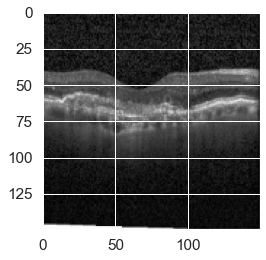

In [66]:
normalized_image = test_images[0] / 255.0

plt.imshow(normalized_image)
plt.show()

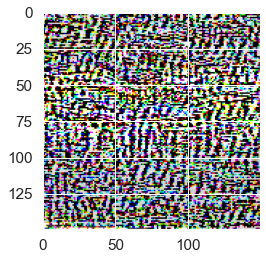

In [67]:
# Viewing an adversarial image
normalized_image = test_images_adv[0] / 255.0

plt.imshow(normalized_image)
plt.show()

In [68]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [69]:
# Testing the model for clean images
score_clean = model.evaluate(
    x=test_images, 
    y=test_labels
    )

# Testing the model for adversarial images
score_adv = model.evaluate(
    x=test_images_adv, 
    y=test_labels
    )

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} " 
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f} " 
      f"vs adversarial test set accuracy: {score_adv[1]:.2f}")

Clean test set loss: 1.30 vs adversarial set test loss: 50.65
Clean test set accuracy: 0.70 vs adversarial test set accuracy: 0.21


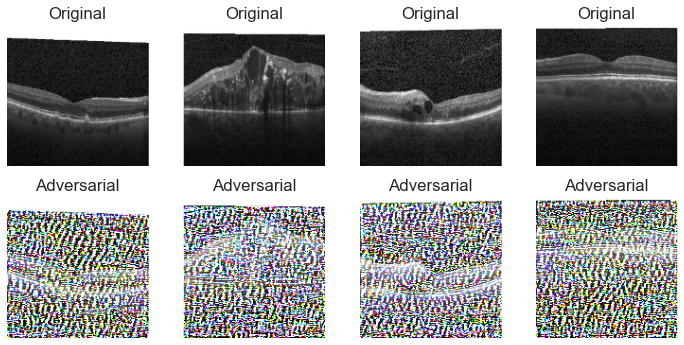

In [60]:
epsilon = 500

# Create FGSM attack object
attack_fgsm_extreme = FastGradientMethod(estimator=classifier, eps=epsilon)

# Generate adversarial noise with extreme noise and distortion
adv_noise_extreme = attack_fgsm_extreme.generate(x=test_images)

# Add adversarial noise to original images
test_images_adv = test_images + adv_noise_extreme

# Clip the pixel values to be within [0, 255]
test_images_adv = np.clip(test_images_adv, 0, 255)

# Normalize pixel values to the range [0, 1]
test_images_adv_normalized = test_images_adv / 255.0

random_indices = np.random.choice(len(test_images), 4, replace=False)

# Plot original and adversarial images 
plt.figure(figsize=(10, 5))
for i, index in enumerate(random_indices, start=1): 
    plt.subplot(2, 4, i)
    plt.imshow(test_images[index] / 255.0)  
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, 4, i + 4)
    plt.imshow(test_images_adv_normalized[index])
    plt.title('Adversarial')
    plt.axis('off')

plt.tight_layout()
plt.show()

